# requirements

In [43]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL
import PIL.Image
import xml.etree.cElementTree as ET

from tensorflow import keras as ks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import kerastuner as kt

import labelImg

from tqdm.notebook import tqdm as tn
from pathlib import Path
import random

import os
import shutil

In [44]:
tf.__version__

'2.4.1'

In [45]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [46]:
tf.test.is_built_with_cuda(),tf.test.is_built_with_gpu_support()

(True, True)

In [47]:
from keras import backend as K

In [48]:
plt.rcParams["figure.figsize"] = [20, 10] 
plt.rcParams["axes.grid"]=True
plt.rcParams["font.size"]=16

In [49]:
from numba import cuda 

In [50]:
device = cuda.get_current_device()

# eda dataset

In [19]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  horizontal_flip=True,
                                  rotation_range=1,
                                  zoom_range=[0.95,1.0],
                                  brightness_range=[0.5,1])
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [20]:
train_generator = train_datagen.flow_from_directory('data/Train/',
                                         batch_size=64)
validation_generator = validation_datagen.flow_from_directory('data/Validation/',
                                         batch_size=64)
test_generator = test_datagen.flow_from_directory('data/Test/',
                                        batch_size=64)

Found 10000 images belonging to 2 classes.
Found 502 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


In [21]:
def get_train_validation_test_gens():
    train_datagen = ImageDataGenerator(rescale=1./255,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  horizontal_flip=True,
                                  rotation_range=1,
                                  zoom_range=[0.95,1.0],
                                  brightness_range=[0.5,1])
    validation_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory('data/Train/',
                                             batch_size=64)
    validation_generator = validation_datagen.flow_from_directory('data/Validation/',
                                             batch_size=64)
    test_generator = test_datagen.flow_from_directory('data/Test/',
                                            batch_size=64)
    return train_generator,validation_generator,test_generator

Found 10000 images belonging to 2 classes.
[1. 0.]
[0. 1.]
[0. 1.]


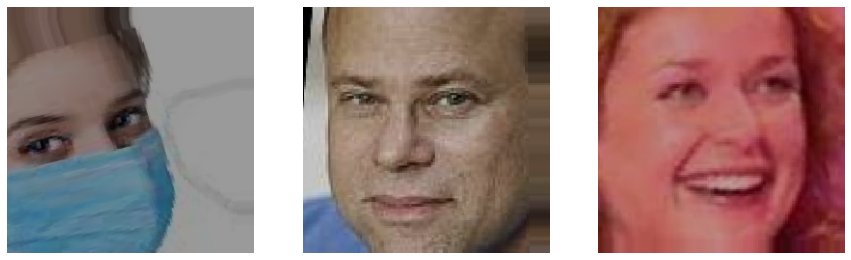

In [38]:
datagen = ImageDataGenerator(brightness_range=[0.5,1],
                             zoom_range=[0.95,1.0],
                             rotation_range=1,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True)

# iterator
aug_iter = datagen.flow_from_directory('data/Train/', batch_size=1)

# generate samples and plot
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,15))

# generate batch of images
for i in range(3):

# convert to unsigned integers
    X_train,y_train = next(aug_iter)
    image = X_train[0].astype('uint8')
    ax[i].imshow(image)
    print(y_train[0])
    ax[i].axis('off')
    plt.plot 

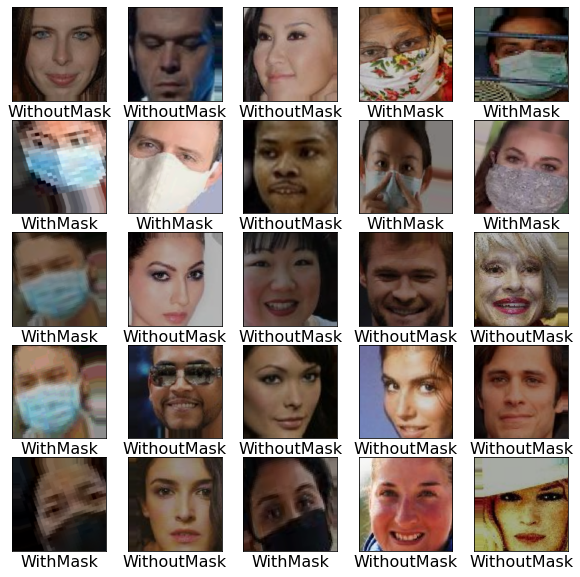

In [23]:
class_names = {v:k for k,v in train_generator.class_indices.items()}
images,labels = next(iter(train_generator))

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(images[i])
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(class_names[labels[i][1]])

plt.show()

In [14]:
X_train, y_train = next(train_generator)
X_val, y_val = next(validation_generator)

In [15]:
X_train.shape, y_train.shape

((64, 256, 256, 3), (64, 2))

In [16]:
def get_model_report(history):
    single_history_df = pd.DataFrame(history.history)
    display(single_history_df.style.background_gradient())
    single_history_df[["AUC",
                   "val_AUC"]].plot()
    single_history_df[["Precision",
                   "val_Precision",
                   "Recall",
                   "val_Recall"]].plot()
    single_history_df[["loss",
                   "val_loss"]].plot()

# Single Softmax

In [31]:
model = ks.models.Sequential()
model.add(ks.layers.Input(shape = (256, 256, 3)))
model.add(ks.layers.Flatten())
model.add(ks.layers.Dense(2))
model.add(ks.layers.Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=ks.optimizers.Adam(0.01),
              metrics=[ks.metrics.CategoricalAccuracy(),
                       ks.metrics.AUC(name="AUC"),
                       ks.metrics.Precision(name="Precision"),
                       ks.metrics.Recall(name="Recall")])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 196608)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 393218    
_________________________________________________________________
activation_9 (Activation)    (None, 2)                 0         
Total params: 393,218
Trainable params: 393,218
Non-trainable params: 0
_________________________________________________________________


In [32]:
# Customize callbacks every new task   
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2,
                                     verbose=1),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./models/model_single_softmax.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs/single_softmax')
]


In [33]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    callbacks=my_callbacks, 
                    epochs=15,
                    verbose=1)

Epoch 1/15
157/157 [==============================] - 227s 1s/step - loss: 52.9337 - categorical_accuracy: 0.7412 - AUC: 0.7476 - Precision: 0.7412 - Recall: 0.7412 - val_loss: 28.4878 - val_categorical_accuracy: 0.8187 - val_AUC: 0.8230 - val_Precision: 0.8187 - val_Recall: 0.8187
Epoch 2/15
157/157 [==============================] - 241s 2s/step - loss: 15.2329 - categorical_accuracy: 0.8367 - AUC: 0.8408 - Precision: 0.8367 - Recall: 0.8367 - val_loss: 10.1905 - val_categorical_accuracy: 0.9004 - val_AUC: 0.9010 - val_Precision: 0.9004 - val_Recall: 0.9004
Epoch 3/15
157/157 [==============================] - 235s 2s/step - loss: 14.8389 - categorical_accuracy: 0.8179 - AUC: 0.8239 - Precision: 0.8179 - Recall: 0.8179 - val_loss: 113.9301 - val_categorical_accuracy: 0.5279 - val_AUC: 0.5286 - val_Precision: 0.5279 - val_Recall: 0.5279
Epoch 4/15
157/157 [==============================] - 238s 2s/step - loss: 24.8279 - categorical_accuracy: 0.8158 - AUC: 0.8209 - Precision: 0.8158 - 

In [73]:
def get_model_report(history):
    single_history_df = pd.DataFrame(history.history)
    display(single_history_df.style.background_gradient())
    single_history_df[["AUC",
                   "val_AUC"]].plot()
    single_history_df[["Precision",
                   "val_Precision",
                   "Recall",
                   "val_Recall"]].plot()
    single_history_df[["loss",
                   "val_loss"]].plot()

In [54]:
single_history_df = pd.DataFrame(history.history)

In [55]:
single_history_df.style.background_gradient()

In [58]:
single_history_df.columns

Index(['loss', 'categorical_accuracy', 'AUC', 'Precision', 'Recall',
       'val_loss', 'val_categorical_accuracy', 'val_AUC', 'val_Precision',
       'val_Recall'],
      dtype='object')

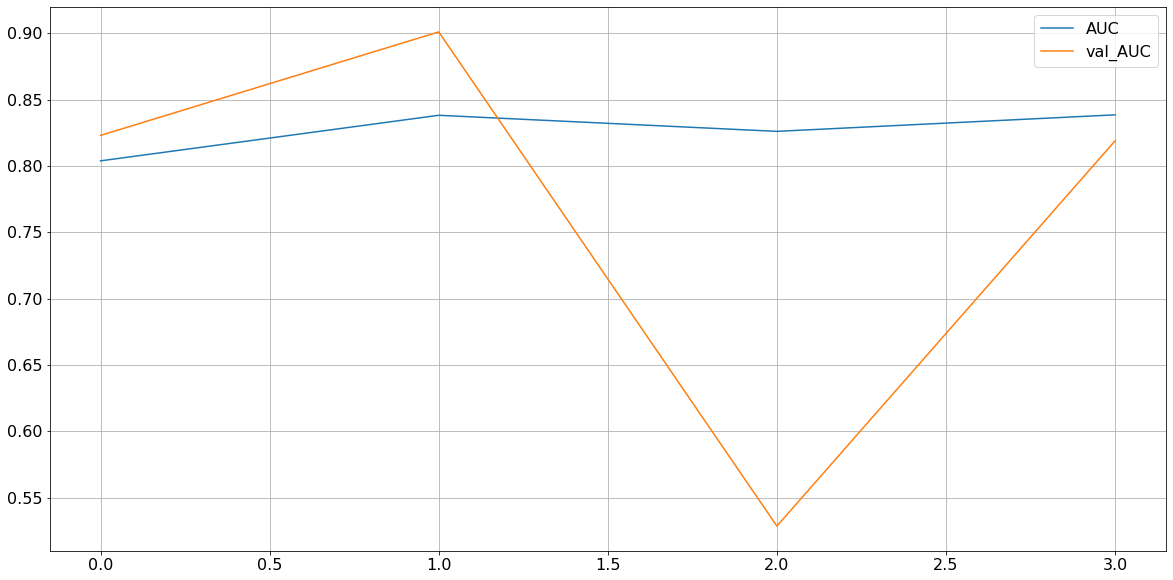

In [61]:
single_history_df[["AUC",
                   "val_AUC"]].plot()

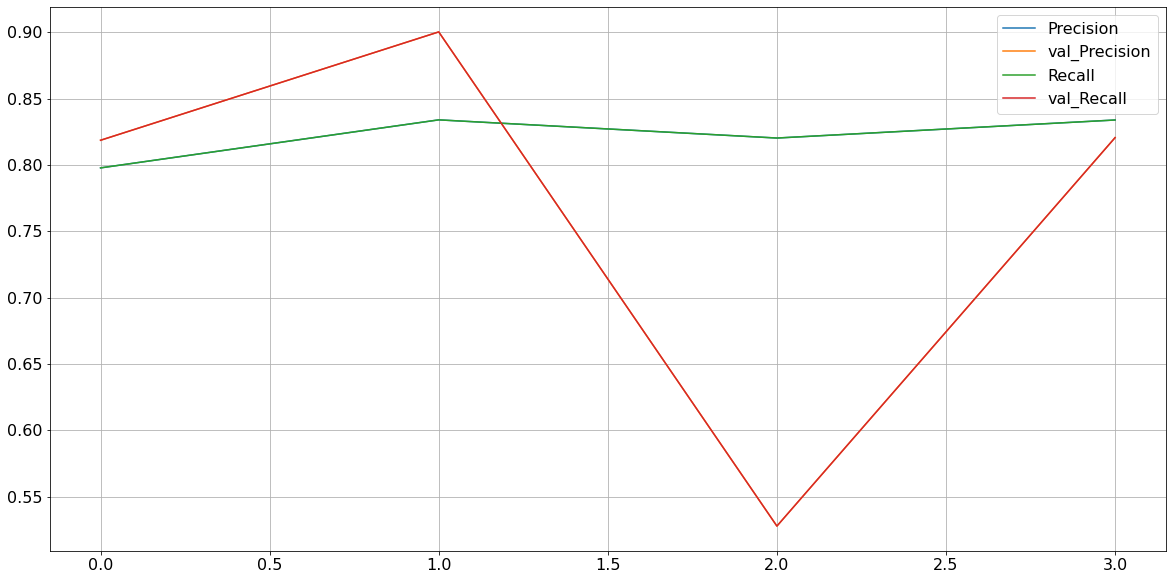

In [62]:
single_history_df[["Precision",
                   "val_Precision",
                   "Recall",
                   "val_Recall"]].plot()

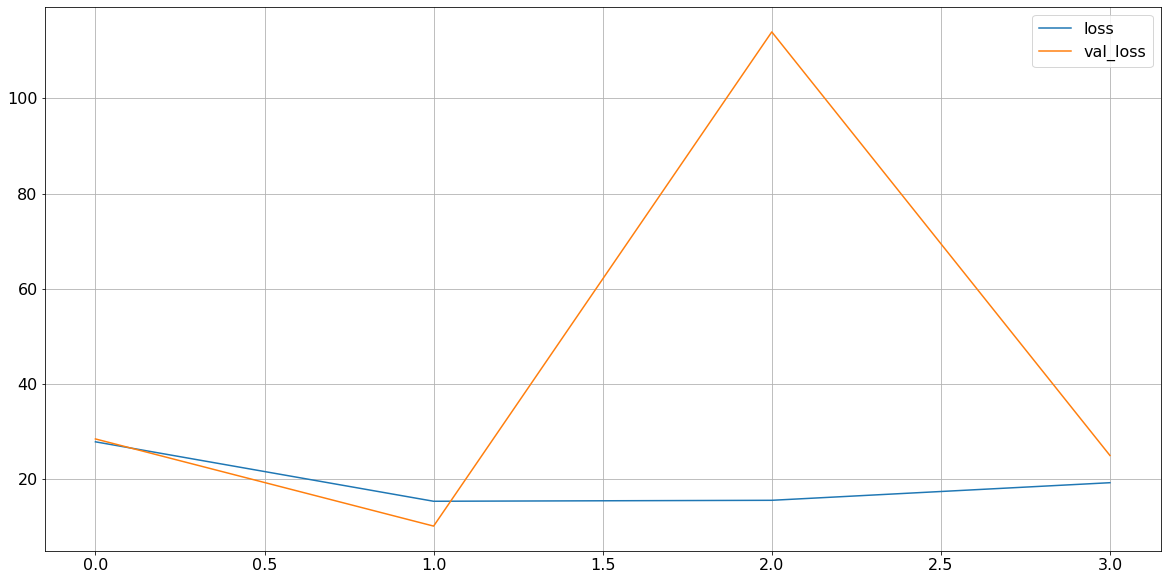

In [64]:
single_history_df[["loss",
                   "val_loss"]].plot()

# MLP tanh Glorot

In [69]:
model = ks.models.Sequential()
model.add(ks.layers.Input(shape = (256, 256, 3)))
model.add(ks.layers.Flatten())
model.add(ks.layers.Dense(256,kernel_initializer=ks.initializers.GlorotNormal(seed=0)))
model.add(ks.layers.Activation('tanh'))
model.add(ks.layers.Dense(64,kernel_initializer=ks.initializers.GlorotNormal(seed=0)))
model.add(ks.layers.Activation('tanh'))
model.add(ks.layers.Dense(2,kernel_initializer=ks.initializers.GlorotNormal(seed=0)))
model.add(ks.layers.Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=ks.optimizers.Adam(0.01),
              metrics=[ks.metrics.CategoricalAccuracy(),
                       ks.metrics.AUC(name="AUC"),
                       ks.metrics.Precision(name="Precision"),
                       ks.metrics.Recall(name="Recall")])

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 196608)            0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               50331904  
_________________________________________________________________
activation_18 (Activation)   (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                16448     
_________________________________________________________________
activation_19 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 130       
_________________________________________________________________
activation_20 (Activation)   (None, 2)                

In [70]:
train_generator,validation_generator,test_generator = get_train_validation_test_gens()

Found 10000 images belonging to 2 classes.
Found 502 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


In [71]:
# Customize callbacks every new task   
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2,
                                     verbose=1),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./models/model_glorot_softmax.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs/glorot')
]


In [72]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    callbacks=my_callbacks, 
                    epochs=15,
                    verbose=1)

Epoch 1/15
157/157 [==============================] - 202s 1s/step - loss: 0.8936 - categorical_accuracy: 0.5023 - AUC: 0.4982 - Precision: 0.5023 - Recall: 0.5023 - val_loss: 0.8663 - val_categorical_accuracy: 0.2072 - val_AUC: 0.2103 - val_Precision: 0.2072 - val_Recall: 0.2072
Epoch 2/15
157/157 [==============================] - 203s 1s/step - loss: 0.7056 - categorical_accuracy: 0.5162 - AUC: 0.5166 - Precision: 0.5162 - Recall: 0.5162 - val_loss: 0.9649 - val_categorical_accuracy: 0.2072 - val_AUC: 0.2103 - val_Precision: 0.2072 - val_Recall: 0.2072
Epoch 3/15
157/157 [==============================] - 205s 1s/step - loss: 0.7137 - categorical_accuracy: 0.4991 - AUC: 0.4944 - Precision: 0.4991 - Recall: 0.4991 - val_loss: 0.7057 - val_categorical_accuracy: 0.2072 - val_AUC: 0.2103 - val_Precision: 0.2072 - val_Recall: 0.2072
Epoch 4/15
157/157 [==============================] - 210s 1s/step - loss: 0.7026 - categorical_accuracy: 0.5014 - AUC: 0.5004 - Precision: 0.5014 - Recall: 

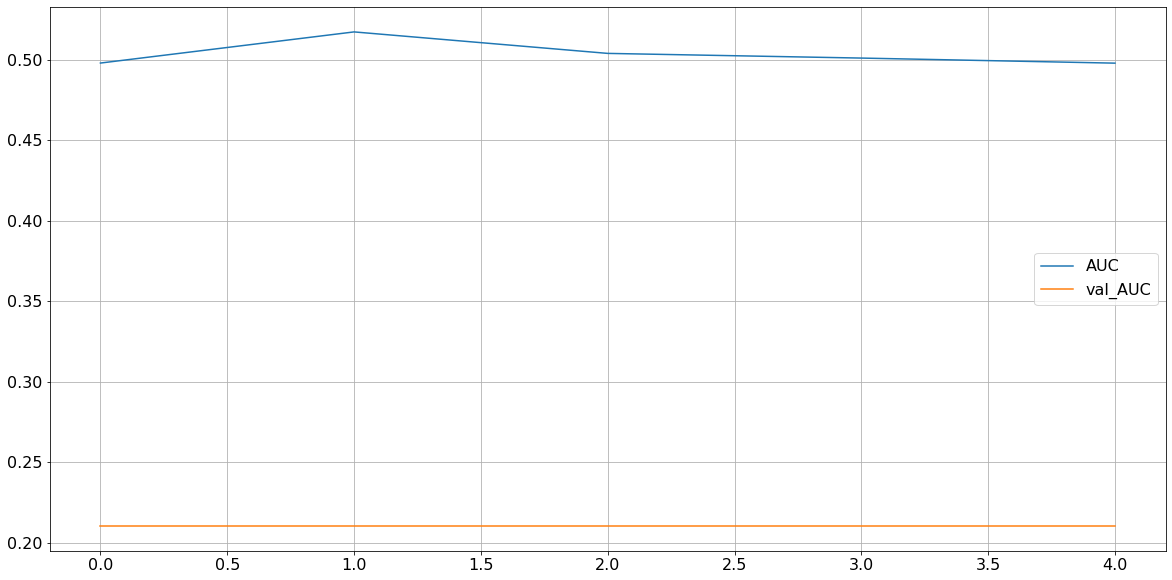

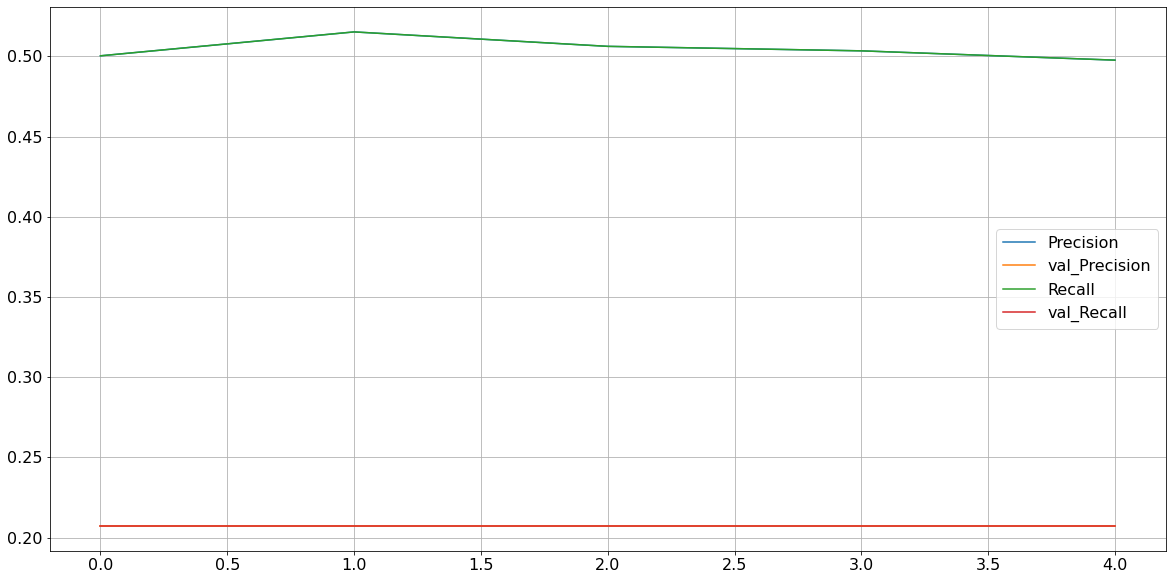

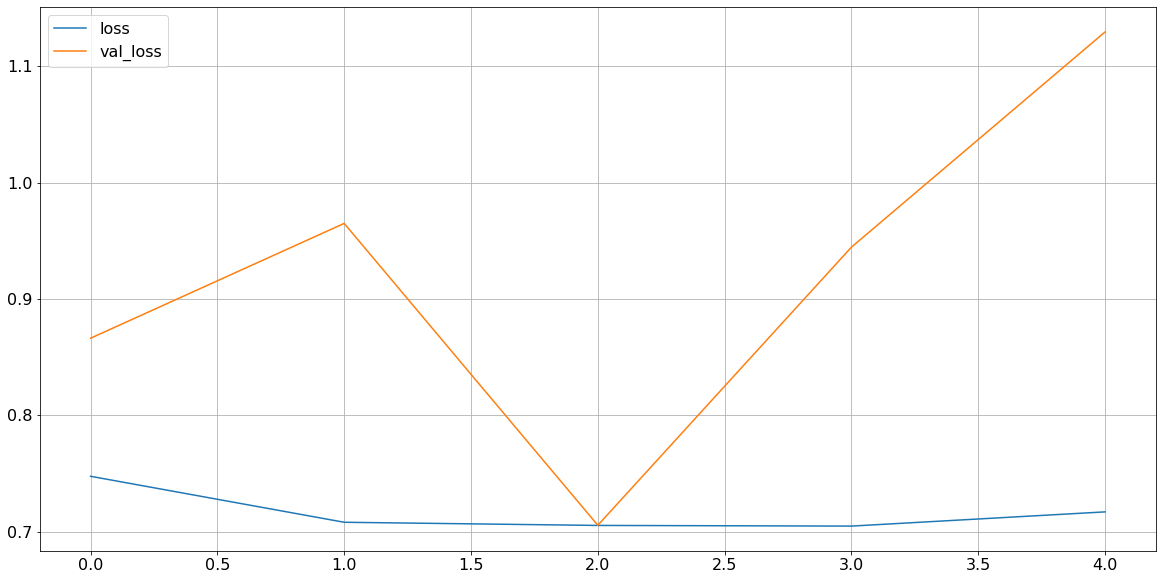

In [74]:
get_model_report(history)

# MLP ReLU He

In [75]:
model = ks.models.Sequential()
model.add(ks.layers.Input(shape = (256, 256, 3)))
model.add(ks.layers.Flatten())
model.add(ks.layers.Dense(256,kernel_initializer=ks.initializers.HeNormal(seed=0)))
model.add(ks.layers.Activation('relu'))
model.add(ks.layers.Dense(64,kernel_initializer=ks.initializers.HeNormal(seed=0)))
model.add(ks.layers.Activation('relu'))
model.add(ks.layers.Dense(2,kernel_initializer=ks.initializers.HeNormal(seed=0)))
model.add(ks.layers.Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=ks.optimizers.Adam(0.01),
              metrics=[ks.metrics.CategoricalAccuracy(),
                       ks.metrics.AUC(name="AUC"),
                       ks.metrics.Precision(name="Precision"),
                       ks.metrics.Recall(name="Recall")])

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 196608)            0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               50331904  
_________________________________________________________________
activation_21 (Activation)   (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 64)                16448     
_________________________________________________________________
activation_22 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 130       
_________________________________________________________________
activation_23 (Activation)   (None, 2)                

In [76]:
train_generator,validation_generator,test_generator = get_train_validation_test_gens()

Found 10000 images belonging to 2 classes.
Found 502 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


In [77]:
# Customize callbacks every new task   
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2,
                                     verbose=1),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./models/model_he_softmax.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs/he')
]


In [78]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    callbacks=my_callbacks, 
                    epochs=15,
                    verbose=1)

Epoch 1/15
157/157 [==============================] - 207s 1s/step - loss: 252.4868 - categorical_accuracy: 0.6716 - AUC: 0.6769 - Precision: 0.6714 - Recall: 0.6711 - val_loss: 15.6044 - val_categorical_accuracy: 0.5000 - val_AUC: 0.5019 - val_Precision: 0.5000 - val_Recall: 0.5000
Epoch 2/15
157/157 [==============================] - 212s 1s/step - loss: 2.0150 - categorical_accuracy: 0.8342 - AUC: 0.8720 - Precision: 0.8342 - Recall: 0.8342 - val_loss: 0.8413 - val_categorical_accuracy: 0.7948 - val_AUC: 0.8848 - val_Precision: 0.7948 - val_Recall: 0.7948
Epoch 3/15
157/157 [==============================] - 202s 1s/step - loss: 0.4797 - categorical_accuracy: 0.8665 - AUC: 0.9333 - Precision: 0.8665 - Recall: 0.8665 - val_loss: 0.4367 - val_categorical_accuracy: 0.8984 - val_AUC: 0.9441 - val_Precision: 0.8984 - val_Recall: 0.8984
Epoch 4/15
157/157 [==============================] - 198s 1s/step - loss: 0.2855 - categorical_accuracy: 0.8963 - AUC: 0.9550 - Precision: 0.8963 - Recal

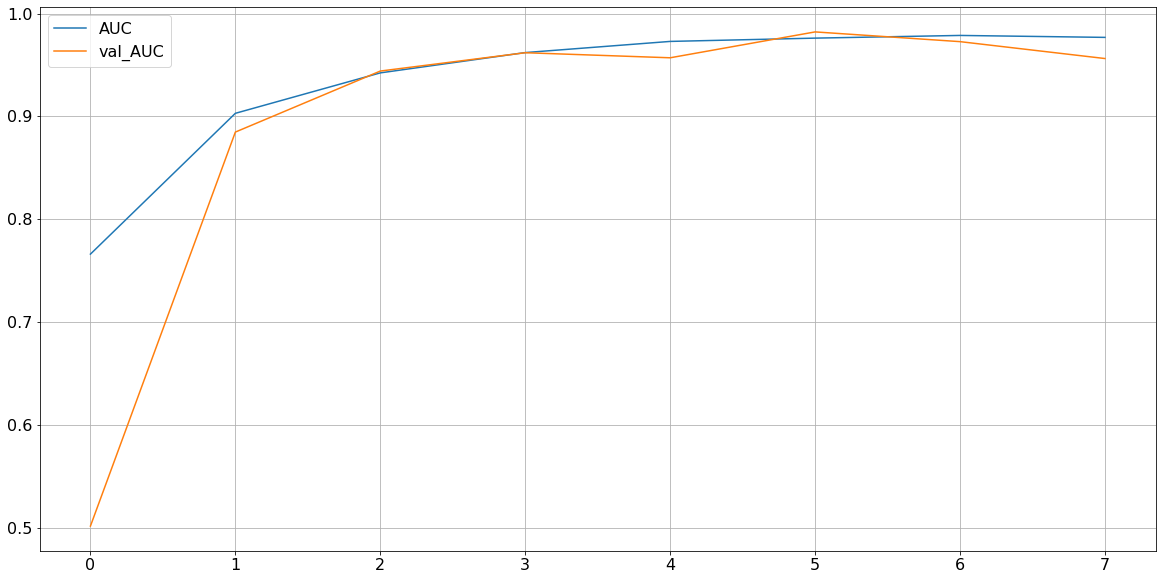

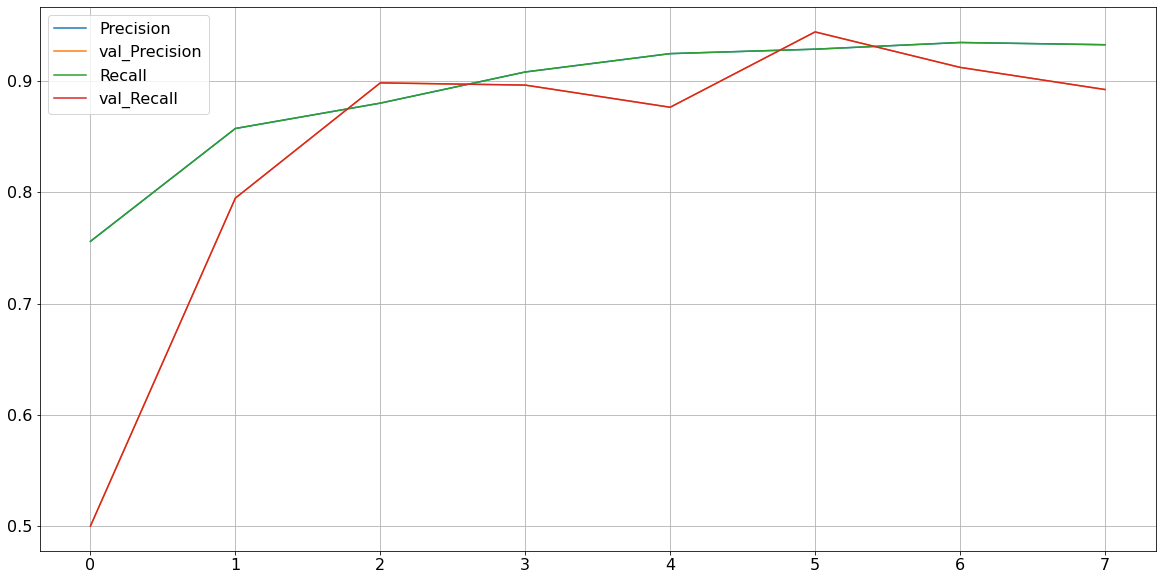

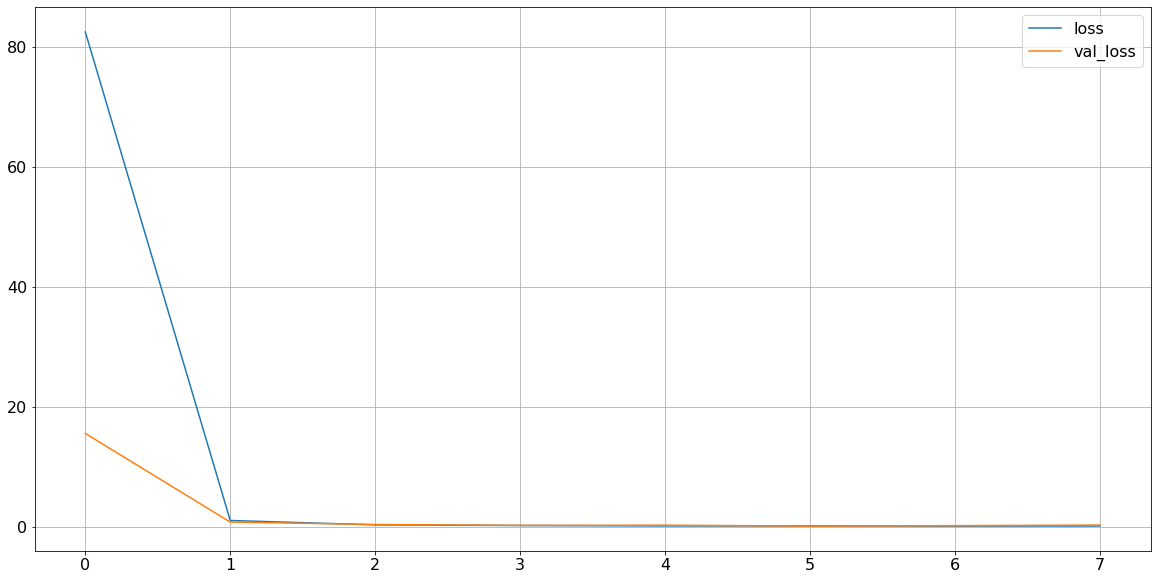

In [79]:
get_model_report(history)

As we can see, He initialization with Relu is better

# ELU 

In [17]:
model = ks.models.Sequential()
model.add(ks.layers.Input(shape = (256, 256, 3)))
model.add(ks.layers.Flatten())
model.add(ks.layers.Dense(256,kernel_initializer=ks.initializers.HeNormal(seed=0)))
model.add(ks.layers.Activation('elu'))
model.add(ks.layers.Dense(64,kernel_initializer=ks.initializers.HeNormal(seed=0)))
model.add(ks.layers.Activation('elu'))
model.add(ks.layers.Dense(2,kernel_initializer=ks.initializers.HeNormal(seed=0)))
model.add(ks.layers.Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=ks.optimizers.Adam(0.01),
              metrics=[ks.metrics.CategoricalAccuracy(),
                       ks.metrics.AUC(name="AUC"),
                       ks.metrics.Precision(name="Precision"),
                       ks.metrics.Recall(name="Recall")])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 196608)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               50331904  
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
_________________________________________________________________
activation_2 (Activation)    (None, 2)                 0

In [18]:
train_generator,validation_generator,test_generator = get_train_validation_test_gens()

Found 10000 images belonging to 2 classes.
Found 502 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


In [19]:
# Customize callbacks every new task   
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2,
                                     verbose=1),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./models/model_he_elu_softmax.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs/he_elu')
]


In [20]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    callbacks=my_callbacks, 
                    epochs=15,
                    verbose=1)

Epoch 1/15
157/157 [==============================] - 191s 1s/step - loss: 273.2915 - categorical_accuracy: 0.6470 - AUC: 0.6572 - Precision: 0.6470 - Recall: 0.6470 - val_loss: 1.0938 - val_categorical_accuracy: 0.6972 - val_AUC: 0.8314 - val_Precision: 0.6972 - val_Recall: 0.6972
Epoch 2/15
157/157 [==============================] - 204s 1s/step - loss: 0.4007 - categorical_accuracy: 0.8496 - AUC: 0.9215 - Precision: 0.8496 - Recall: 0.8496 - val_loss: 0.4009 - val_categorical_accuracy: 0.7948 - val_AUC: 0.9126 - val_Precision: 0.7948 - val_Recall: 0.7948
Epoch 3/15
157/157 [==============================] - 201s 1s/step - loss: 0.3063 - categorical_accuracy: 0.8857 - AUC: 0.9497 - Precision: 0.8857 - Recall: 0.8857 - val_loss: 0.3912 - val_categorical_accuracy: 0.8665 - val_AUC: 0.9381 - val_Precision: 0.8665 - val_Recall: 0.8665
Epoch 4/15
157/157 [==============================] - 198s 1s/step - loss: 4.5016 - categorical_accuracy: 0.8102 - AUC: 0.8725 - Precision: 0.8102 - Recall

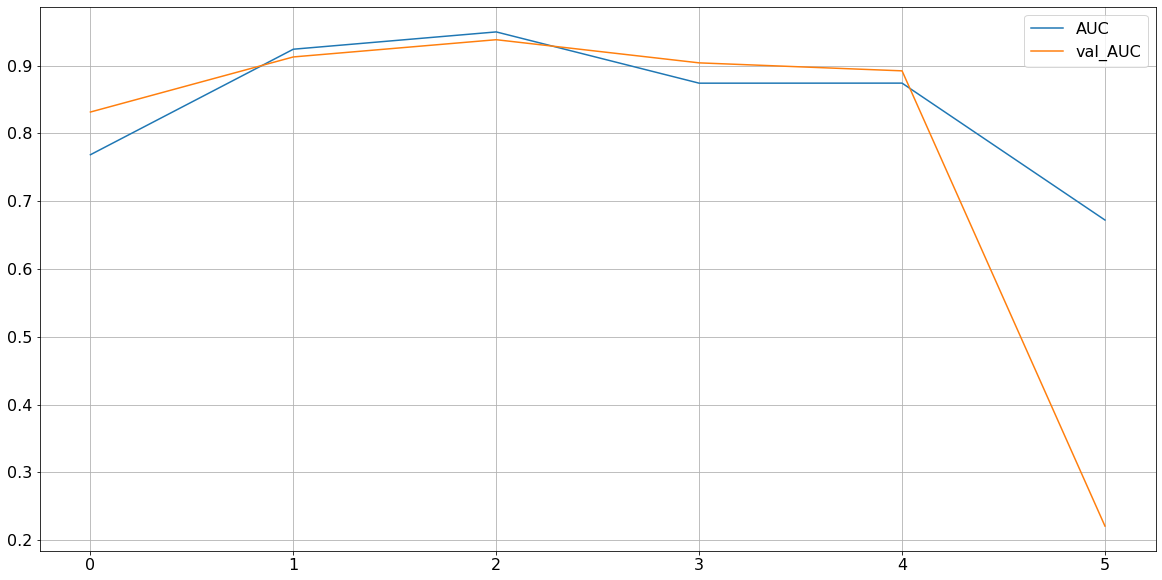

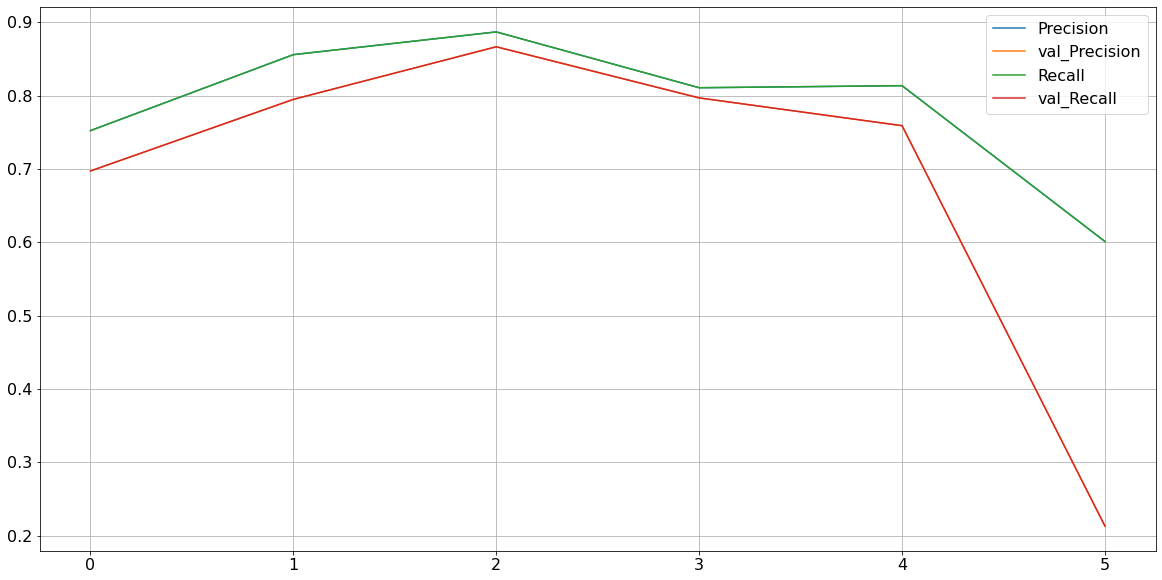

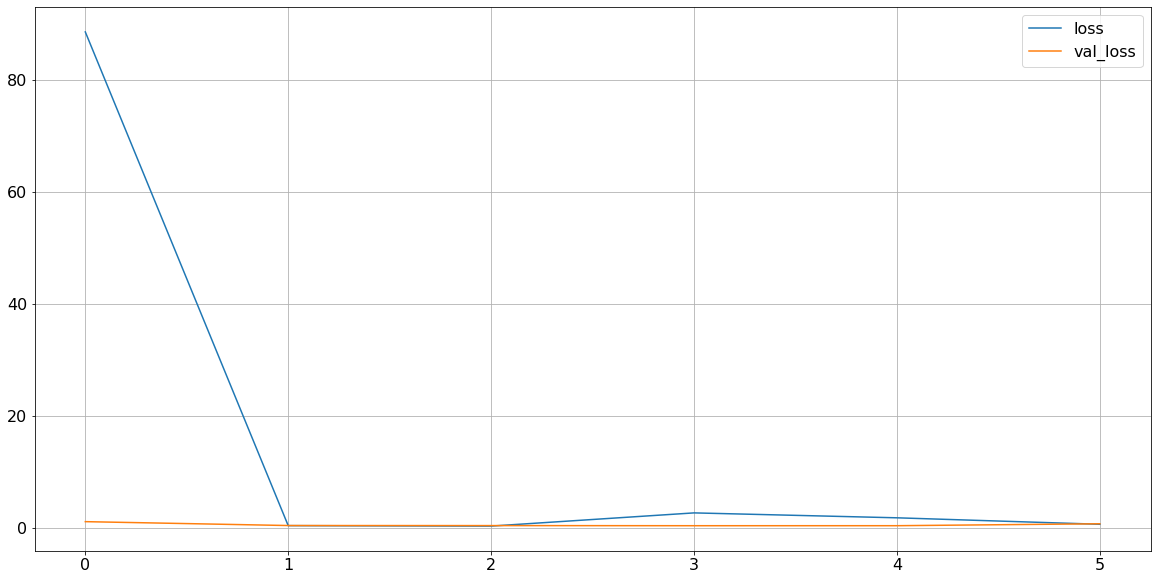

In [21]:
get_model_report(history)

# SGD

In [22]:
model = ks.models.Sequential()
model.add(ks.layers.Input(shape = (256, 256, 3)))
model.add(ks.layers.Flatten())
model.add(ks.layers.Dense(256,kernel_initializer=ks.initializers.HeNormal(seed=0)))
model.add(ks.layers.Activation('relu'))
model.add(ks.layers.Dense(64,kernel_initializer=ks.initializers.HeNormal(seed=0)))
model.add(ks.layers.Activation('relu'))
model.add(ks.layers.Dense(2,kernel_initializer=ks.initializers.HeNormal(seed=0)))
model.add(ks.layers.Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=ks.optimizers.SGD(0.01),
              metrics=[ks.metrics.CategoricalAccuracy(),
                       ks.metrics.AUC(name="AUC"),
                       ks.metrics.Precision(name="Precision"),
                       ks.metrics.Recall(name="Recall")])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 196608)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               50331904  
_________________________________________________________________
activation_3 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                16448     
_________________________________________________________________
activation_4 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 130       
_________________________________________________________________
activation_5 (Activation)    (None, 2)                

In [23]:
train_generator,validation_generator,test_generator = get_train_validation_test_gens()

Found 10000 images belonging to 2 classes.
Found 502 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


In [24]:
# Customize callbacks every new task   
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2,
                                     verbose=1),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./models/model_he_sgd_softmax.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs/he_sgd')
]


In [25]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    callbacks=my_callbacks, 
                    epochs=15,
                    verbose=1)

Epoch 1/15
157/157 [==============================] - 181s 1s/step - loss: 1.2948 - categorical_accuracy: 0.6383 - AUC: 0.6687 - Precision: 0.6383 - Recall: 0.6383 - val_loss: 0.5905 - val_categorical_accuracy: 0.7510 - val_AUC: 0.8308 - val_Precision: 0.7510 - val_Recall: 0.7510
Epoch 2/15
157/157 [==============================] - 204s 1s/step - loss: 0.3511 - categorical_accuracy: 0.8520 - AUC: 0.9239 - Precision: 0.8520 - Recall: 0.8520 - val_loss: 0.3124 - val_categorical_accuracy: 0.8526 - val_AUC: 0.9488 - val_Precision: 0.8526 - val_Recall: 0.8526
Epoch 3/15
157/157 [==============================] - 198s 1s/step - loss: 0.2891 - categorical_accuracy: 0.8834 - AUC: 0.9484 - Precision: 0.8834 - Recall: 0.8834 - val_loss: 0.4479 - val_categorical_accuracy: 0.8307 - val_AUC: 0.9232 - val_Precision: 0.8307 - val_Recall: 0.8307
Epoch 4/15
157/157 [==============================] - 192s 1s/step - loss: 0.2432 - categorical_accuracy: 0.9055 - AUC: 0.9628 - Precision: 0.9055 - Recall: 

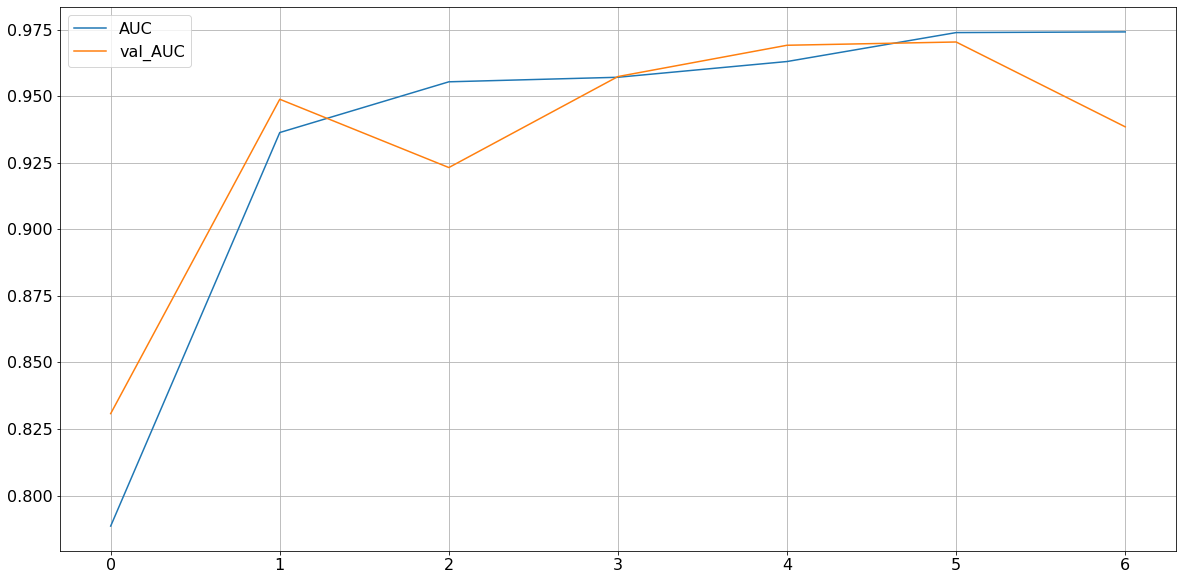

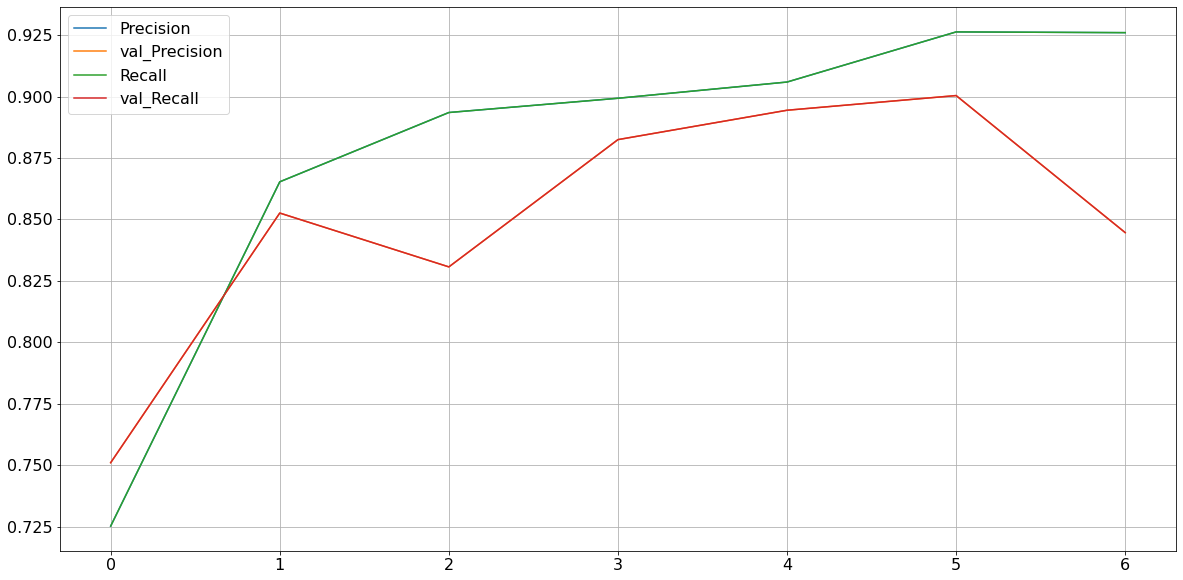

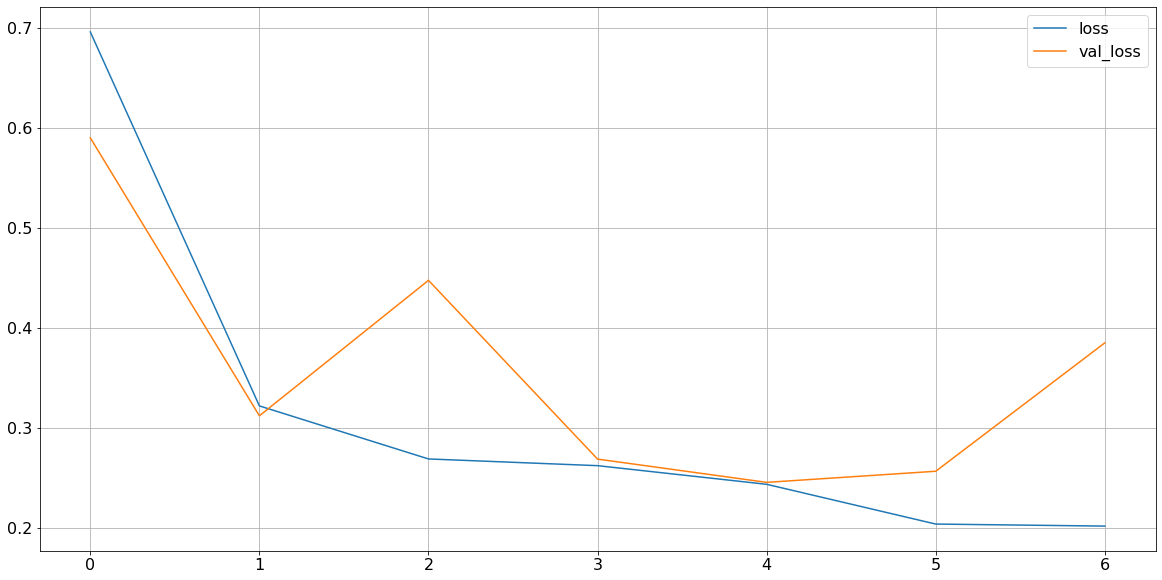

In [26]:
get_model_report(history)

Adam is better in comparison with SGD.

# Batch Normalization

In [27]:
model = ks.models.Sequential()
model.add(ks.layers.Input(shape = (256, 256, 3)))
model.add(ks.layers.Flatten())
model.add(ks.layers.Dense(256,kernel_initializer=ks.initializers.HeNormal(seed=0)))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.Activation('relu'))
model.add(ks.layers.Dense(64,kernel_initializer=ks.initializers.HeNormal(seed=0)))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.Activation('relu'))
model.add(ks.layers.Dense(2,kernel_initializer=ks.initializers.HeNormal(seed=0)))
model.add(ks.layers.Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=ks.optimizers.Adam(0.01),
              metrics=[ks.metrics.CategoricalAccuracy(),
                       ks.metrics.AUC(name="AUC"),
                       ks.metrics.Precision(name="Precision"),
                       ks.metrics.Recall(name="Recall")])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 196608)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               50331904  
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
activation_6 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                16448     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
activation_7 (Activation)    (None, 64)               

In [28]:
train_generator,validation_generator,test_generator = get_train_validation_test_gens()

Found 10000 images belonging to 2 classes.
Found 502 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


In [29]:
# Customize callbacks every new task   
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2,
                                     verbose=1),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./models/model_he_batch_norm.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs/he_batch_norm')
]


In [30]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    callbacks=my_callbacks, 
                    epochs=15,
                    verbose=1)

Epoch 1/15
157/157 [==============================] - 198s 1s/step - loss: 0.4161 - categorical_accuracy: 0.8134 - AUC: 0.8876 - Precision: 0.8134 - Recall: 0.8134 - val_loss: 0.6285 - val_categorical_accuracy: 0.7869 - val_AUC: 0.8691 - val_Precision: 0.7869 - val_Recall: 0.7869
Epoch 2/15
157/157 [==============================] - 204s 1s/step - loss: 0.2520 - categorical_accuracy: 0.8971 - AUC: 0.9611 - Precision: 0.8971 - Recall: 0.8971 - val_loss: 0.1561 - val_categorical_accuracy: 0.9223 - val_AUC: 0.9852 - val_Precision: 0.9223 - val_Recall: 0.9223
Epoch 3/15
157/157 [==============================] - 208s 1s/step - loss: 0.1986 - categorical_accuracy: 0.9245 - AUC: 0.9753 - Precision: 0.9245 - Recall: 0.9245 - val_loss: 0.2374 - val_categorical_accuracy: 0.8645 - val_AUC: 0.9621 - val_Precision: 0.8645 - val_Recall: 0.8645
Epoch 4/15
157/157 [==============================] - 202s 1s/step - loss: 0.1553 - categorical_accuracy: 0.9401 - AUC: 0.9850 - Precision: 0.9401 - Recall: 

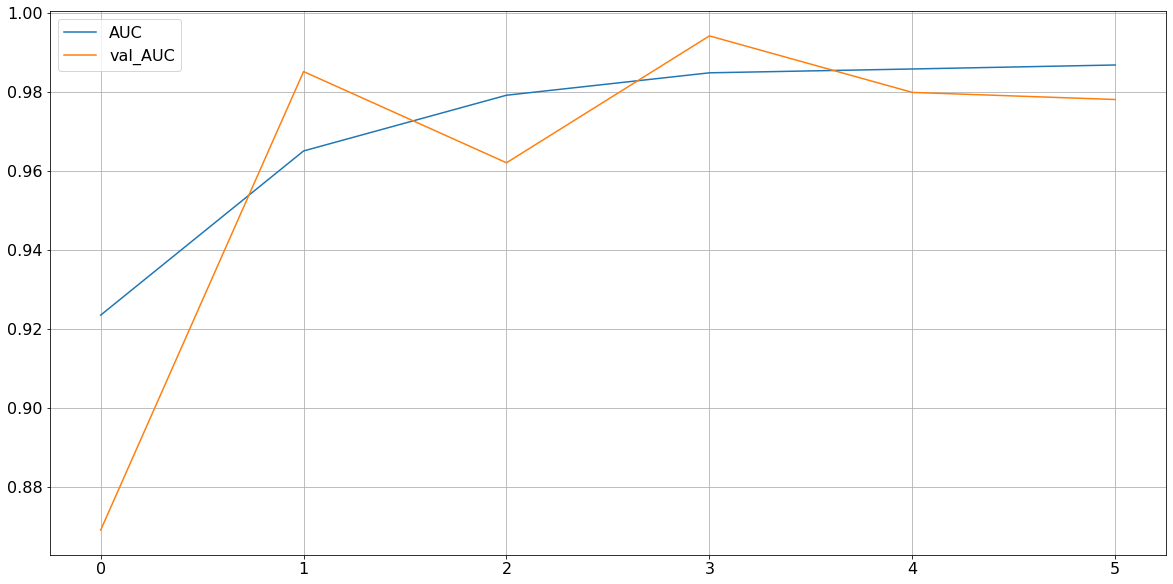

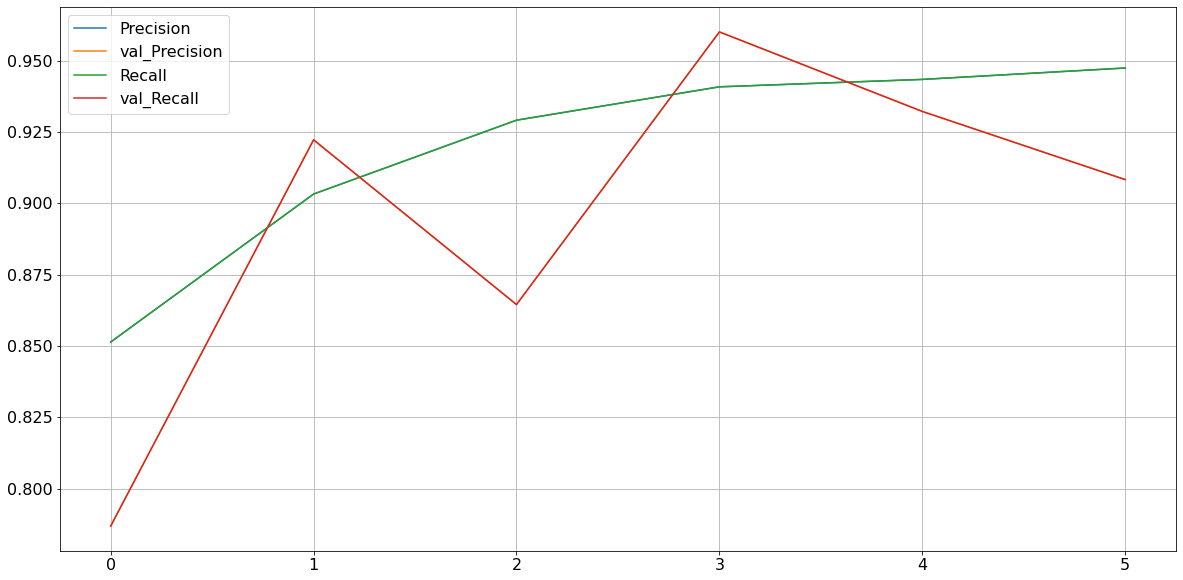

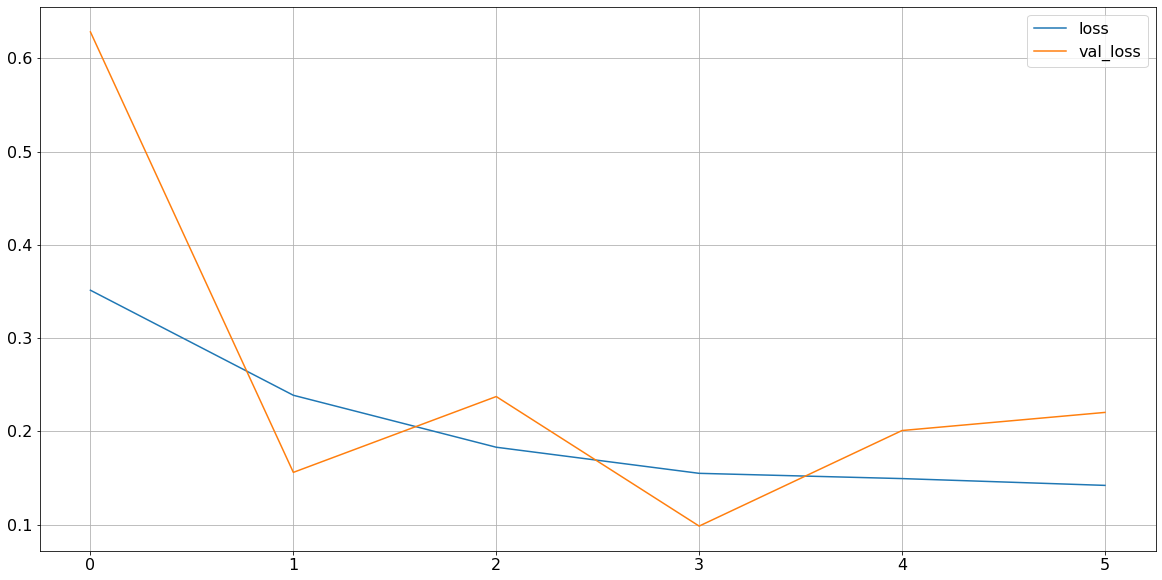

In [31]:
get_model_report(history)

Batch normalization works well<br>
Batch normalization speeds up the machine learning process

# Dropout

In [32]:
model = ks.models.Sequential()
model.add(ks.layers.Input(shape = (256, 256, 3)))
model.add(ks.layers.Flatten())
model.add(ks.layers.Dense(256,kernel_initializer=ks.initializers.HeNormal(seed=0)))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.Activation('relu'))
model.add(ks.layers.Dropout(0.5))
model.add(ks.layers.Dense(64,kernel_initializer=ks.initializers.HeNormal(seed=0)))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.Activation('relu'))
model.add(ks.layers.Dropout(0.5))
model.add(ks.layers.Dense(2,kernel_initializer=ks.initializers.HeNormal(seed=0)))
model.add(ks.layers.Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=ks.optimizers.Adam(0.01),
              metrics=[ks.metrics.CategoricalAccuracy(),
                       ks.metrics.AUC(name="AUC"),
                       ks.metrics.Precision(name="Precision"),
                       ks.metrics.Recall(name="Recall")])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 196608)            0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               50331904  
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
activation_9 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                16448     
_________________________________________________________________
batch_normalization_3 (Batch (None, 64)               

In [33]:
train_generator,validation_generator,test_generator = get_train_validation_test_gens()

Found 10000 images belonging to 2 classes.
Found 502 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


In [34]:
# Customize callbacks every new task   
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2,
                                     verbose=1),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./models/model_he_batch_norm_dropout.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs/he_batch_norm_dropout')
]


In [35]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    callbacks=my_callbacks, 
                    epochs=15,
                    verbose=1)

Epoch 1/15
157/157 [==============================] - 194s 1s/step - loss: 0.5099 - categorical_accuracy: 0.7689 - AUC: 0.8416 - Precision: 0.7689 - Recall: 0.7689 - val_loss: 0.6384 - val_categorical_accuracy: 0.7490 - val_AUC: 0.8589 - val_Precision: 0.7490 - val_Recall: 0.7490
Epoch 2/15
157/157 [==============================] - 209s 1s/step - loss: 0.3550 - categorical_accuracy: 0.8560 - AUC: 0.9222 - Precision: 0.8560 - Recall: 0.8560 - val_loss: 0.2523 - val_categorical_accuracy: 0.8685 - val_AUC: 0.9604 - val_Precision: 0.8685 - val_Recall: 0.8685
Epoch 3/15
157/157 [==============================] - 201s 1s/step - loss: 0.2896 - categorical_accuracy: 0.8809 - AUC: 0.9494 - Precision: 0.8809 - Recall: 0.8809 - val_loss: 0.2351 - val_categorical_accuracy: 0.8705 - val_AUC: 0.9653 - val_Precision: 0.8705 - val_Recall: 0.8705
Epoch 4/15
157/157 [==============================] - 204s 1s/step - loss: 0.2664 - categorical_accuracy: 0.8958 - AUC: 0.9570 - Precision: 0.8958 - Recall: 

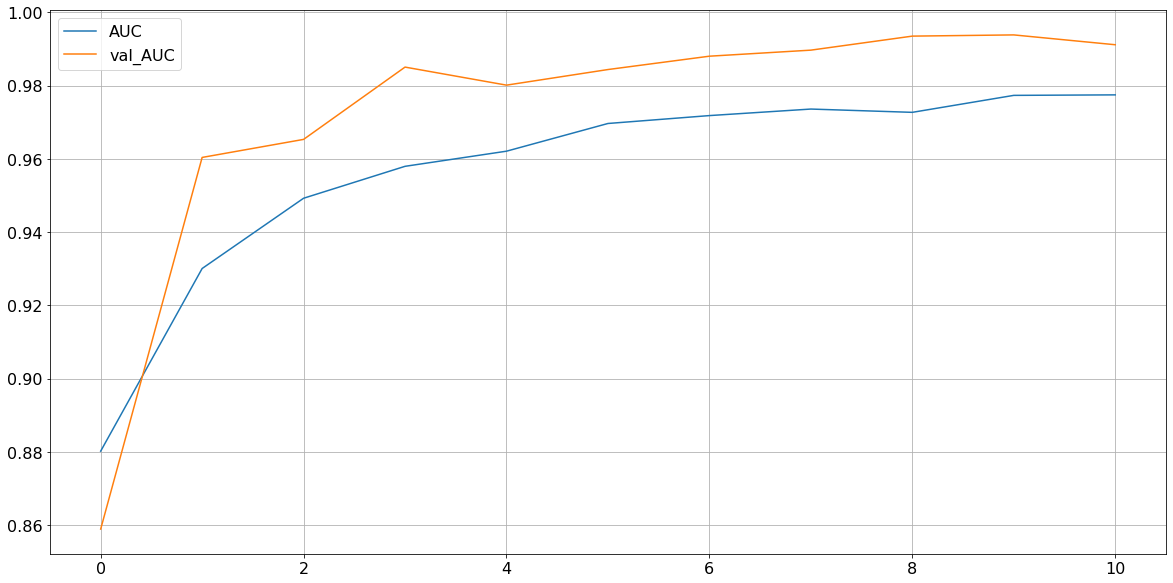

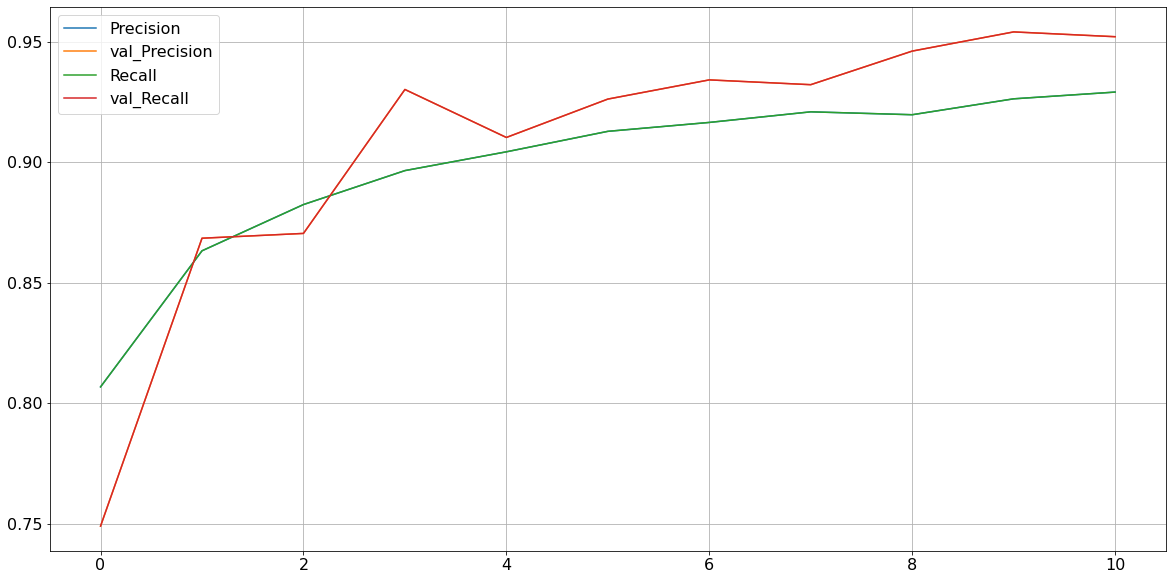

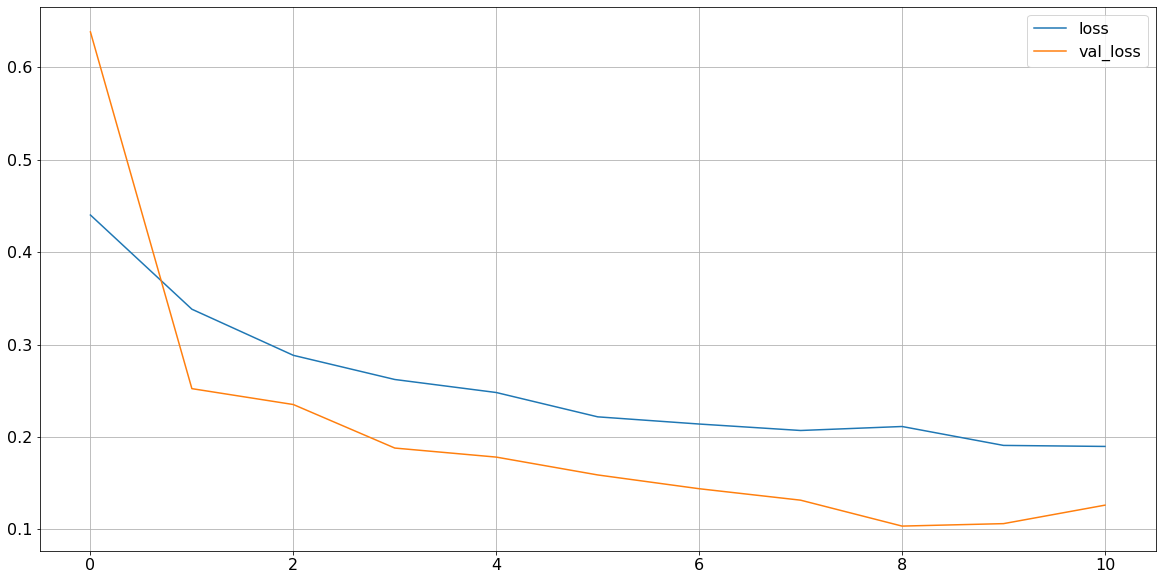

In [36]:
get_model_report(history)

Dropout has regularization effect, so new validation scores are better

# regularization

In [42]:
model = ks.models.Sequential()
model.add(ks.layers.Input(shape = (256, 256, 3)))
model.add(ks.layers.Flatten())
model.add(ks.layers.Dense(256,kernel_initializer=ks.initializers.HeNormal(seed=0),
                         kernel_regularizer=tf.keras.regularizers.l2()))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.Activation('relu'))
model.add(ks.layers.Dropout(0.5))
model.add(ks.layers.Dense(64,kernel_initializer=ks.initializers.HeNormal(seed=0),
                         kernel_regularizer=tf.keras.regularizers.l2()))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.Activation('relu'))
model.add(ks.layers.Dropout(0.5))
model.add(ks.layers.Dense(2,kernel_initializer=ks.initializers.HeNormal(seed=0),
                         kernel_regularizer=tf.keras.regularizers.l2()))
model.add(ks.layers.Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=ks.optimizers.Adam(0.01),
              metrics=[ks.metrics.CategoricalAccuracy(),
                       ks.metrics.AUC(name="AUC"),
                       ks.metrics.Precision(name="Precision"),
                       ks.metrics.Recall(name="Recall")])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 196608)            0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               50331904  
_________________________________________________________________
batch_normalization_6 (Batch (None, 256)               1024      
_________________________________________________________________
activation_15 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                16448     
_________________________________________________________________
batch_normalization_7 (Batch (None, 64)               

In [43]:
train_generator,validation_generator,test_generator = get_train_validation_test_gens()

Found 10000 images belonging to 2 classes.
Found 502 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


In [44]:
# Customize callbacks every new task   
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=4,
                                     verbose=1),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./models/model_he_batch_norm_dropout_l2.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs/he_batch_norm_dropout_l2')
]


In [45]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    callbacks=my_callbacks, 
                    epochs=15,
                    verbose=1)

Epoch 1/15
157/157 [==============================] - 215s 1s/step - loss: 85.6385 - categorical_accuracy: 0.7571 - AUC: 0.8279 - Precision: 0.7571 - Recall: 0.7571 - val_loss: 2.0293 - val_categorical_accuracy: 0.7948 - val_AUC: 0.9013 - val_Precision: 0.7948 - val_Recall: 0.7948
Epoch 2/15
157/157 [==============================] - 218s 1s/step - loss: 2.1715 - categorical_accuracy: 0.7921 - AUC: 0.8736 - Precision: 0.7921 - Recall: 0.7921 - val_loss: 2.5186 - val_categorical_accuracy: 0.7809 - val_AUC: 0.8897 - val_Precision: 0.7809 - val_Recall: 0.7809
Epoch 3/15
157/157 [==============================] - 213s 1s/step - loss: 2.2805 - categorical_accuracy: 0.7914 - AUC: 0.8651 - Precision: 0.7914 - Recall: 0.7914 - val_loss: 2.4288 - val_categorical_accuracy: 0.7769 - val_AUC: 0.8856 - val_Precision: 0.7769 - val_Recall: 0.7769
Epoch 4/15
157/157 [==============================] - 213s 1s/step - loss: 2.3975 - categorical_accuracy: 0.7785 - AUC: 0.8563 - Precision: 0.7785 - Recall:

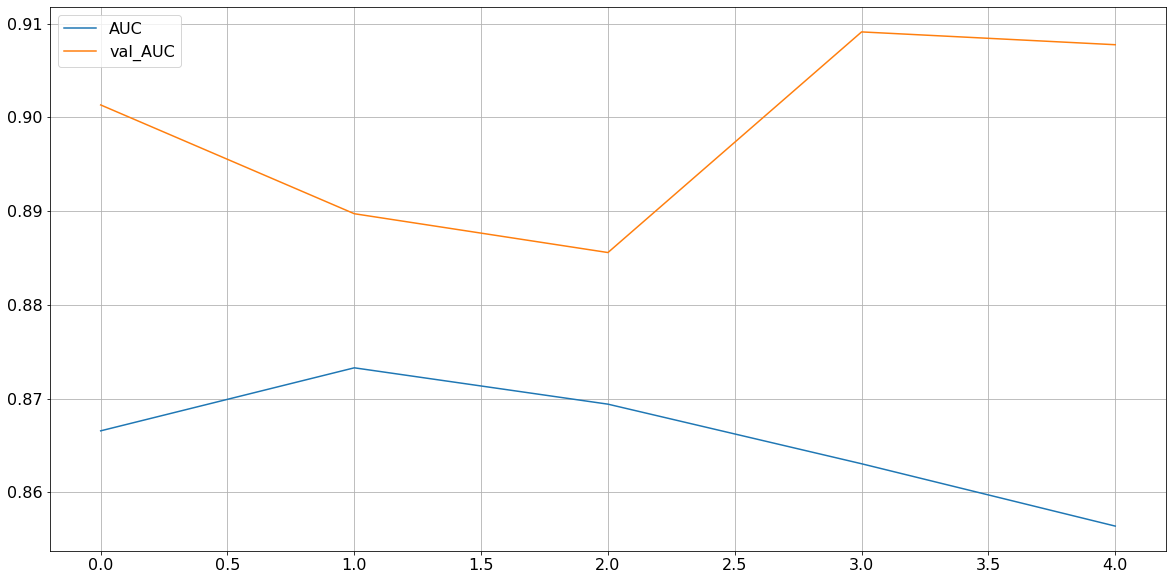

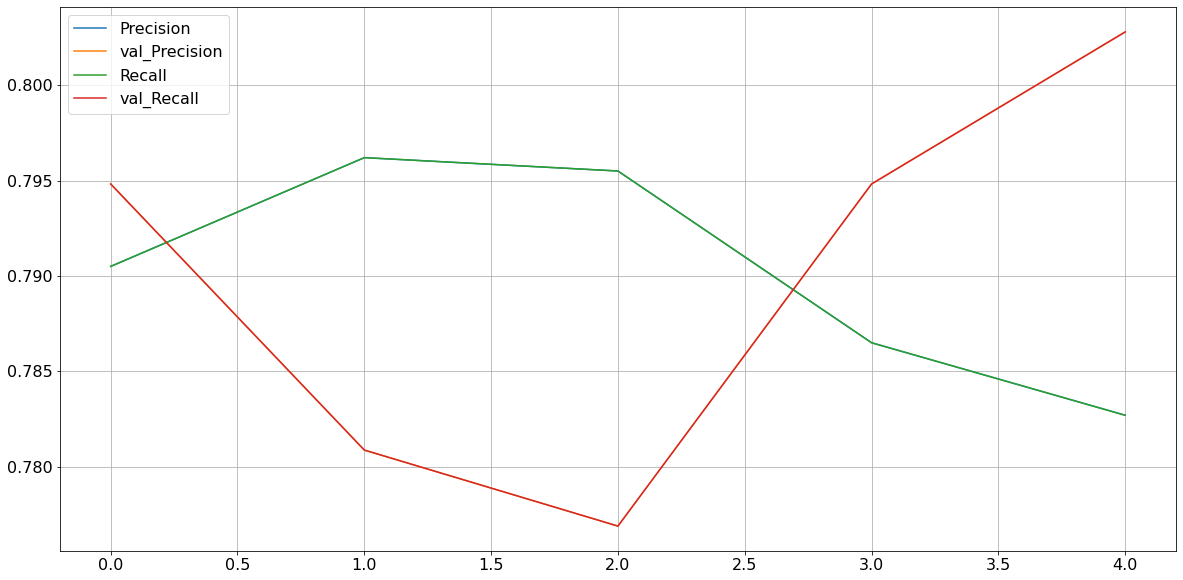

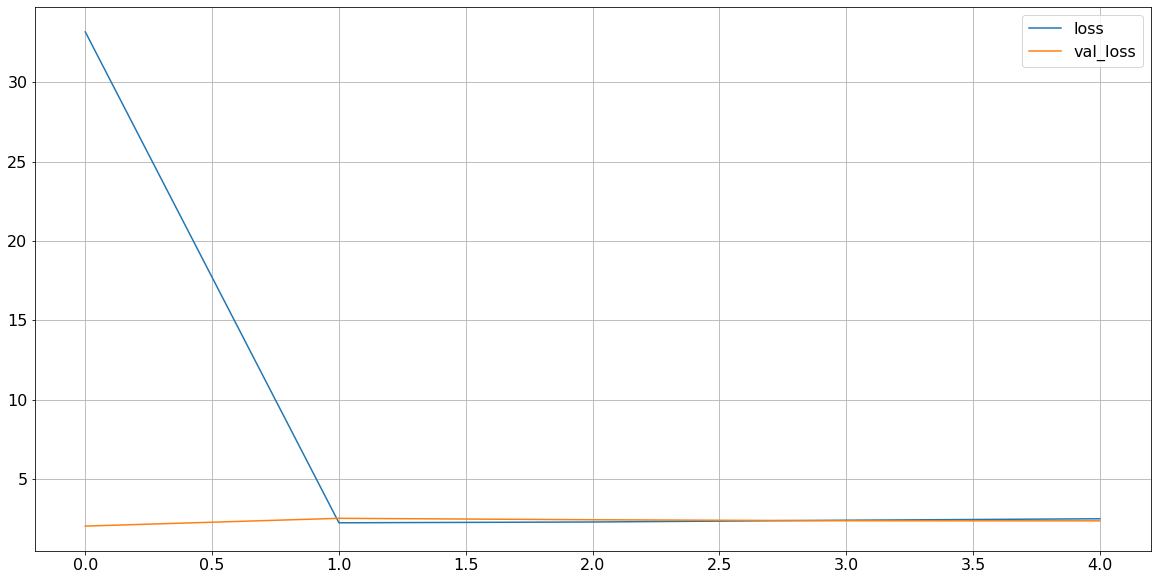

In [46]:
get_model_report(history)

L2 has huge regularization effect and model cannot learn. The best model is ReLU BatchNormalization Dropout model

# test

In [17]:
model = tf.keras.models.load_model('./models/model_he_batch_norm_dropout.h5')

In [51]:
X_test,y_test = next(test_generator)

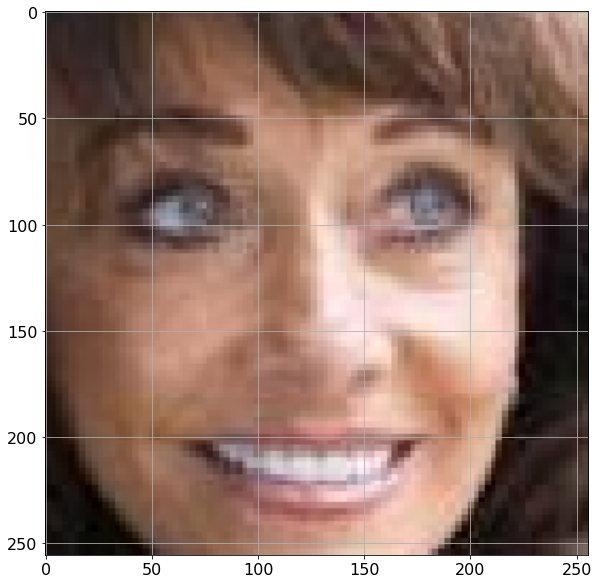

With    Mask proba:0.15384256839752197
Without Mask proba:0.8461573719978333


In [64]:
image_arr = X_test[2]
predictions = model.predict(np.array([image_arr]))    
plt.imshow(image_arr)
plt.show()
print(f"With    Mask proba:{ predictions[0][0]}")
print(f"Without Mask proba:{ predictions[0][1]}")

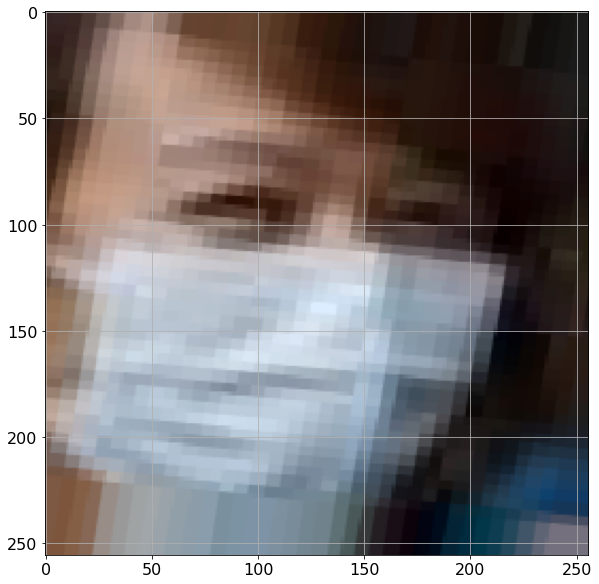

With    Mask proba:0.9999871253967285
Without Mask proba:1.2876624168711714e-05


In [65]:
image_arr = X_test[1]
predictions = model.predict(np.array([image_arr]))    
plt.imshow(image_arr)
plt.show()
print(f"With    Mask proba:{ predictions[0][0]}")
print(f"Without Mask proba:{ predictions[0][1]}")

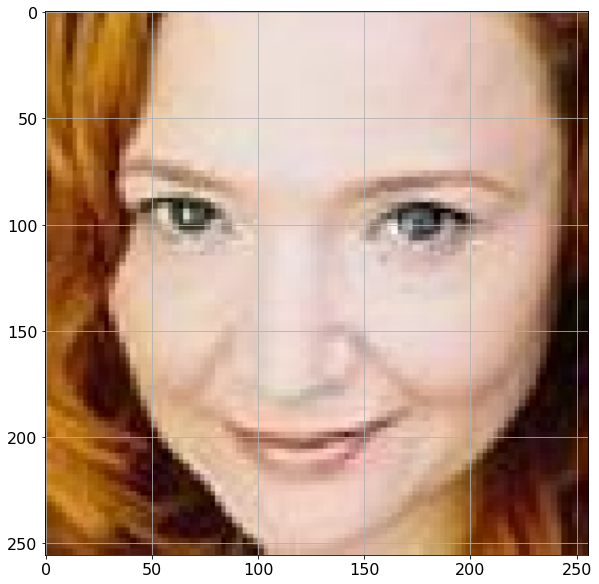

With    Mask proba:0.2746710777282715
Without Mask proba:0.7253289222717285


In [66]:
image_arr = X_test[5]
predictions = model.predict(np.array([image_arr]))    
plt.imshow(image_arr)
plt.show()
print(f"With    Mask proba:{ predictions[0][0]}")
print(f"Without Mask proba:{ predictions[0][1]}")

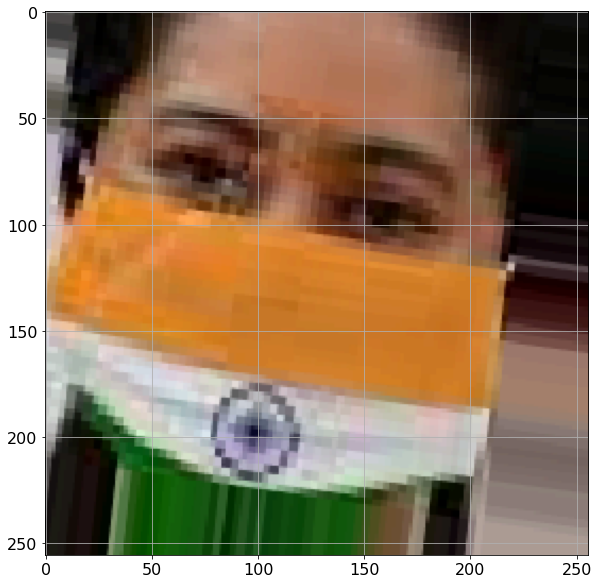

With    Mask proba:0.9949676394462585
Without Mask proba:0.005032363813370466


In [67]:
image_arr = X_test[9]
predictions = model.predict(np.array([image_arr]))    
plt.imshow(image_arr)
plt.show()
print(f"With    Mask proba:{ predictions[0][0]}")
print(f"Without Mask proba:{ predictions[0][1]}")

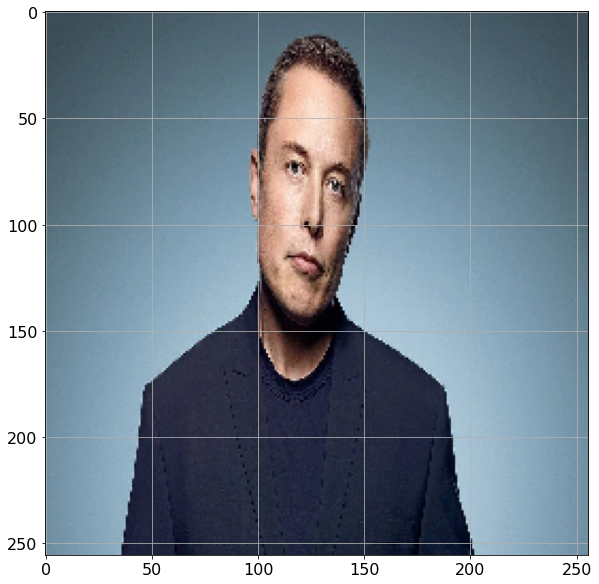

With    Mask proba:0.9850108027458191
Without Mask proba:0.014989184215664864


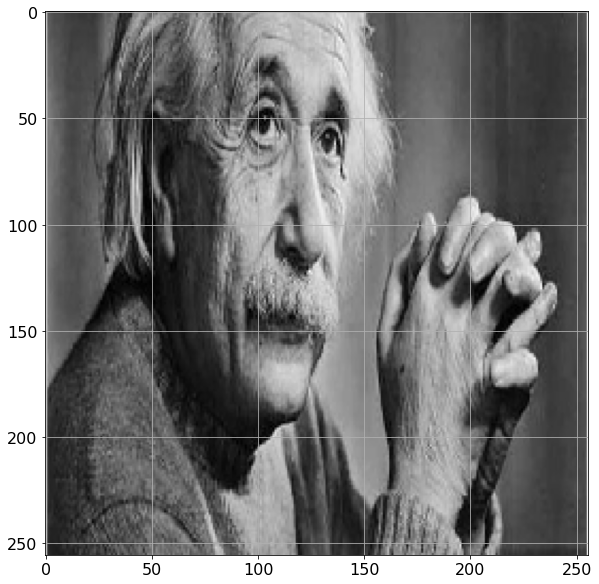

With    Mask proba:0.9954785704612732
Without Mask proba:0.0045214747078716755


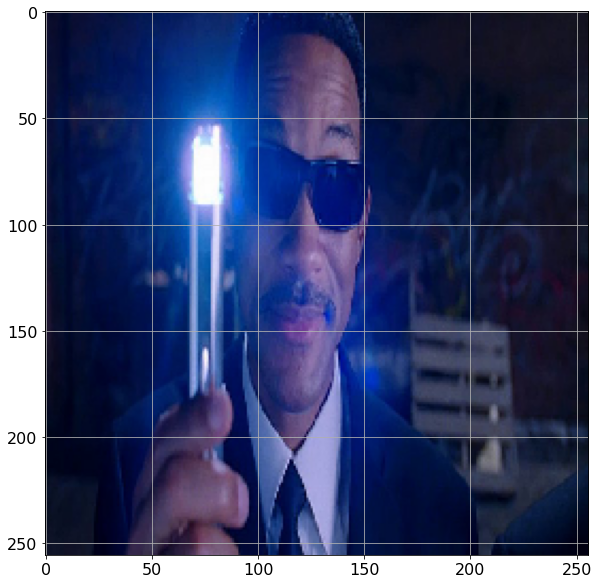

With    Mask proba:0.999433696269989
Without Mask proba:0.0005663170595653355


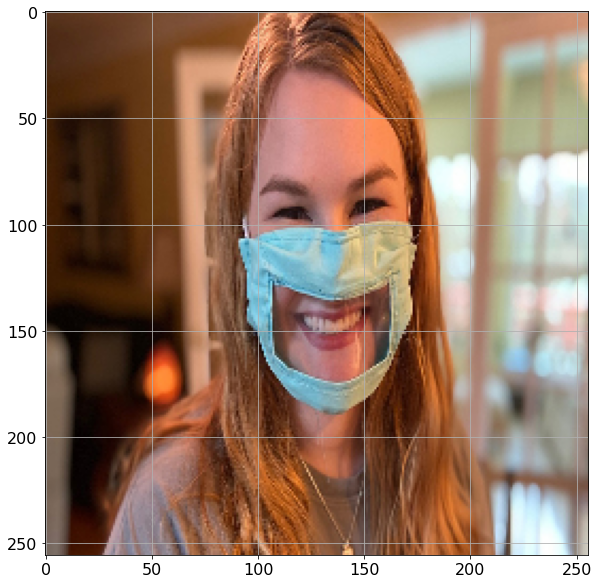

With    Mask proba:0.8154056668281555
Without Mask proba:0.1845943182706833


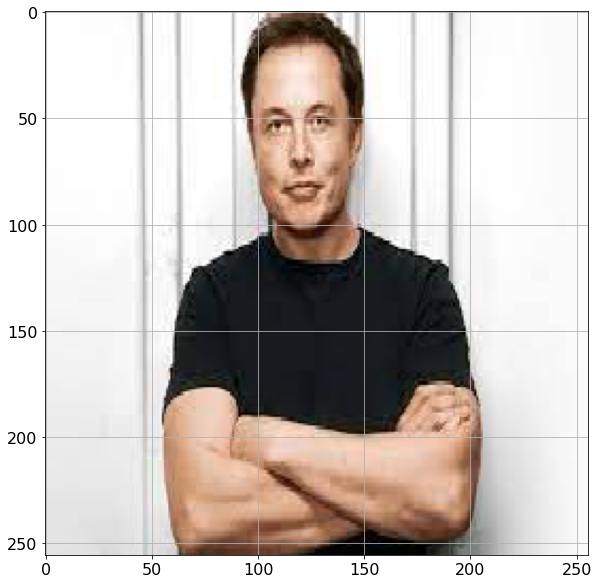

With    Mask proba:0.9999332427978516
Without Mask proba:6.67450949549675e-05


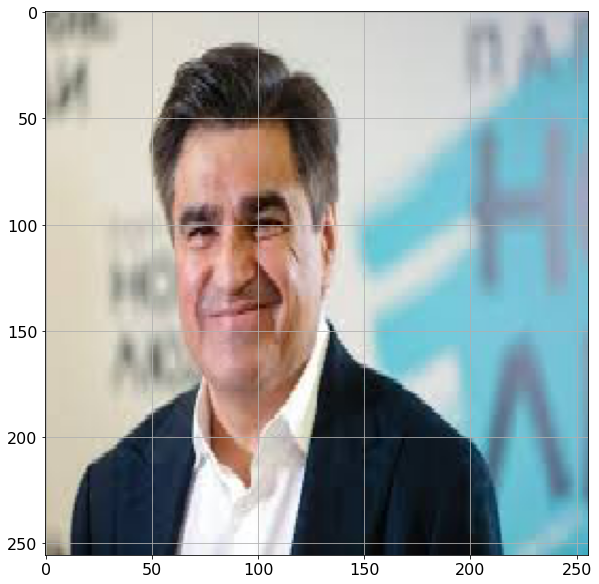

With    Mask proba:0.9956717491149902
Without Mask proba:0.0043282294645905495


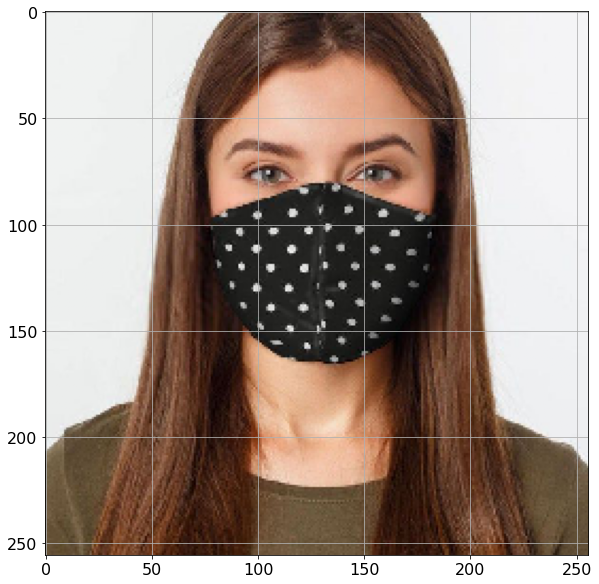

With    Mask proba:0.9666584730148315
Without Mask proba:0.03334159031510353


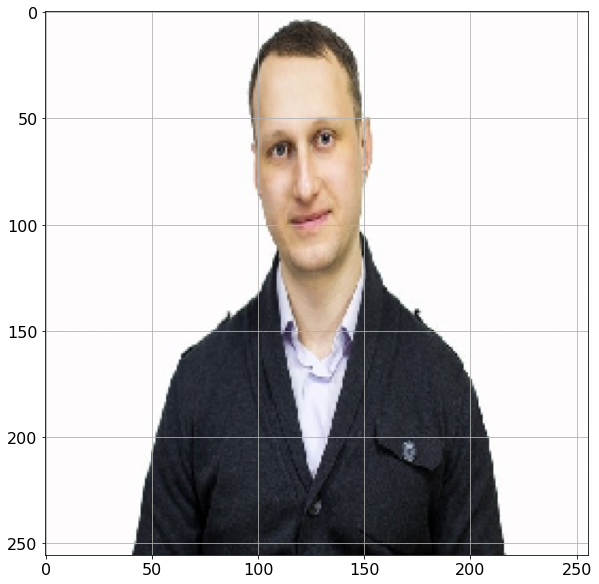

With    Mask proba:0.9999887943267822
Without Mask proba:1.1176161024195608e-05


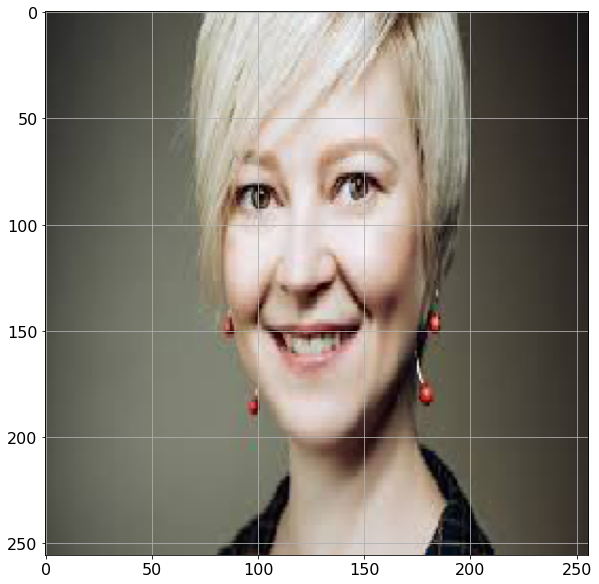

With    Mask proba:0.900713324546814
Without Mask proba:0.09928662329912186


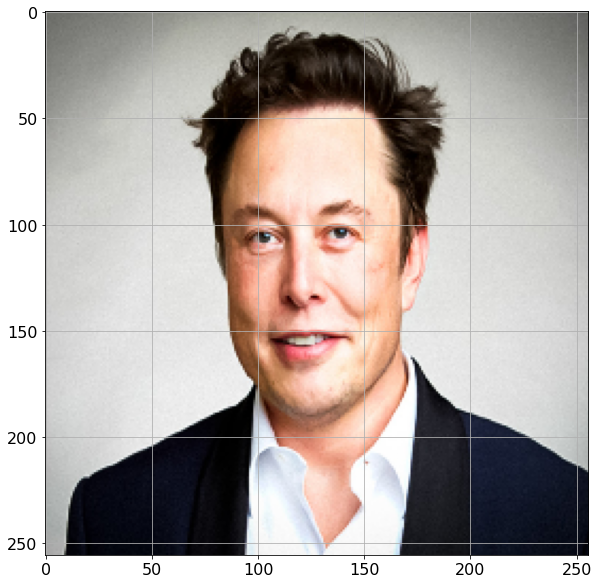

With    Mask proba:0.8045557737350464
Without Mask proba:0.19544421136379242


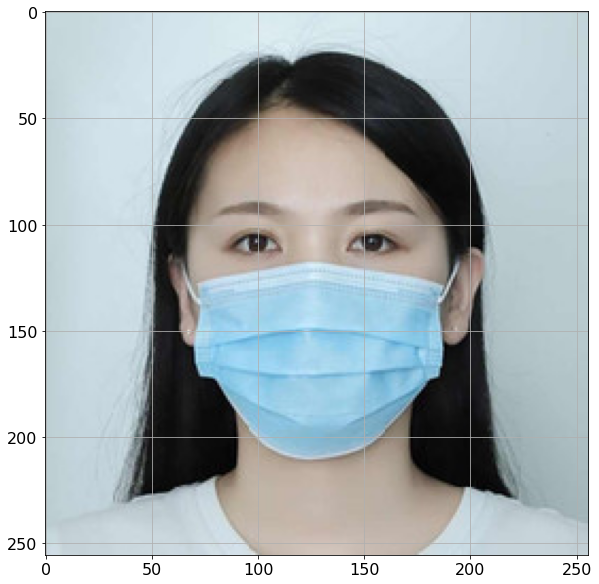

With    Mask proba:0.9999946355819702
Without Mask proba:5.422343292593723e-06


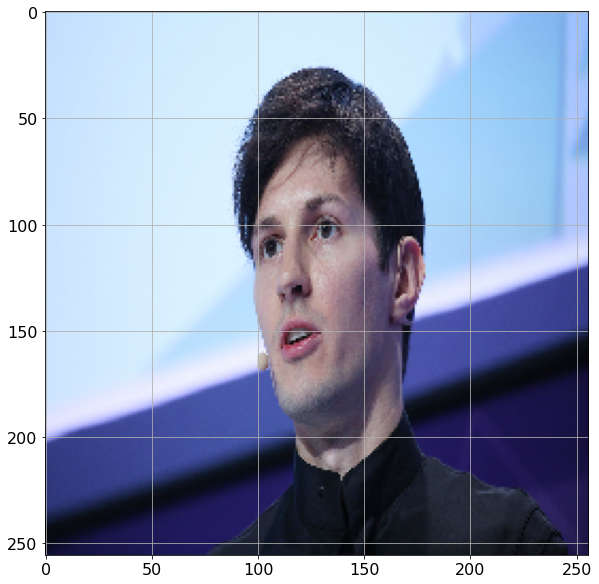

With    Mask proba:0.9983624815940857
Without Mask proba:0.0016375546110793948


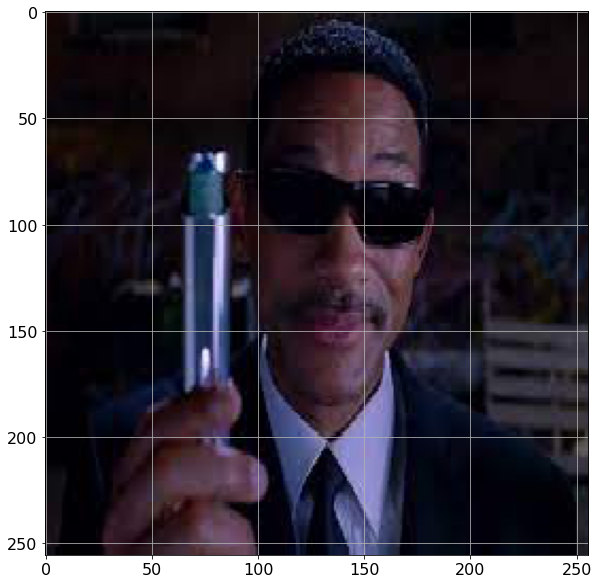

With    Mask proba:0.9964547157287598
Without Mask proba:0.0035452498123049736


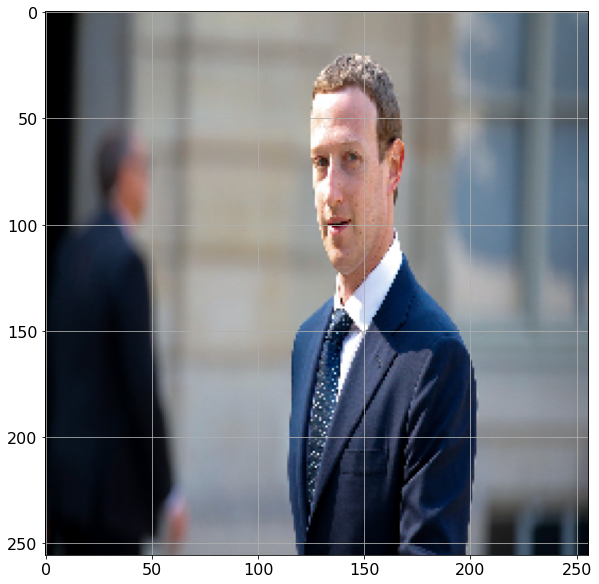

With    Mask proba:0.9997277855873108
Without Mask proba:0.00027216263697482646


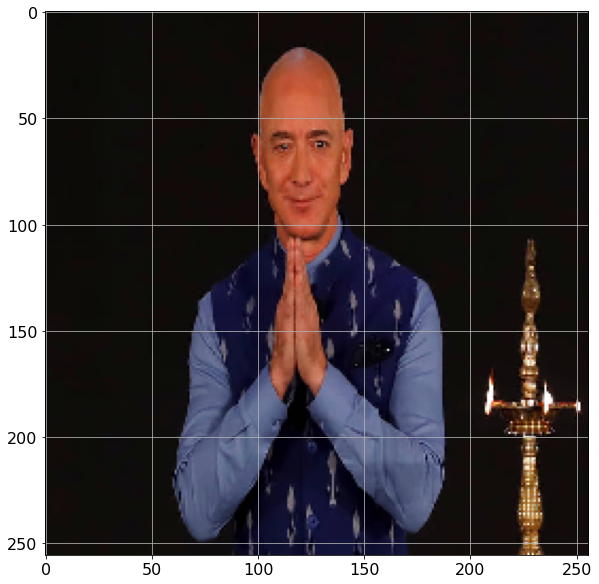

With    Mask proba:0.9995336532592773
Without Mask proba:0.0004664086445700377


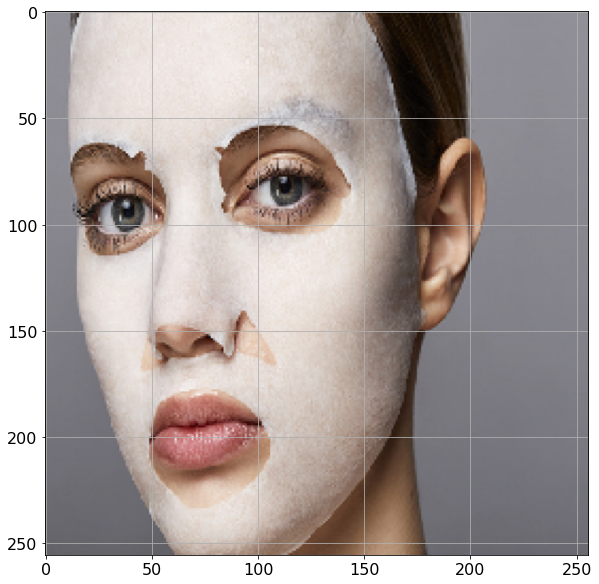

With    Mask proba:0.8981999158859253
Without Mask proba:0.10180003196001053


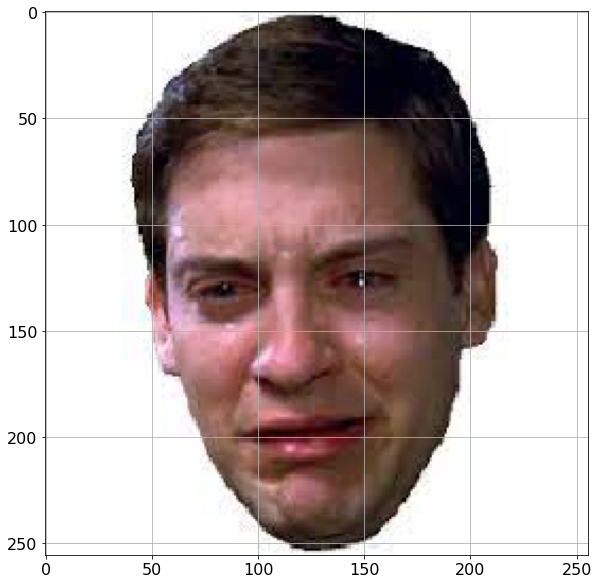

With    Mask proba:0.9687638878822327
Without Mask proba:0.03123609535396099


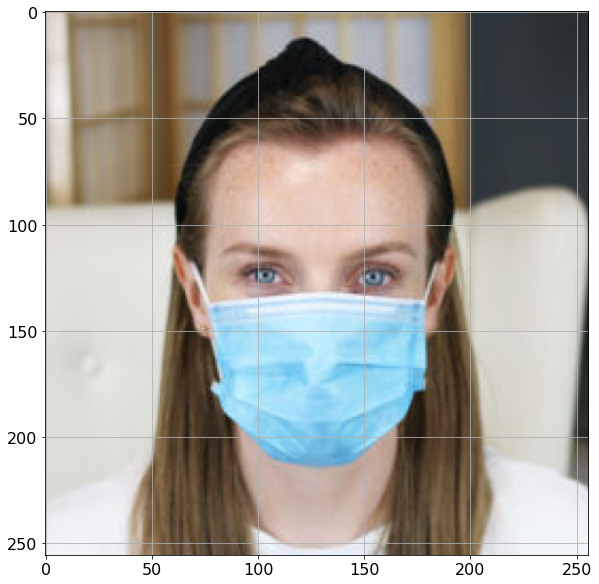

With    Mask proba:0.9999954700469971
Without Mask proba:4.492601419769926e-06


In [76]:
custom_images = [f"./custom_images/{filename}" for filename in os.listdir("./custom_images/")]
for image_path in custom_images:
    custom_image = tf.keras.preprocessing.image.load_img(image_path, target_size=(256, 256))
    image_arr = tf.keras.preprocessing.image.img_to_array(custom_image)
    image_arr /= 255.
    predictions = model.predict(np.array([image_arr]))    
    plt.imshow(image_arr)
    plt.show()
    print(f"With    Mask proba:{ predictions[0][0]}")
    print(f"Without Mask proba:{ predictions[0][1]}")

As we can see, mlp can't deal with real data at all. However, some probabilties without mask are higher than others, so this model can tell us something  anyway. <br>
In conclusion, it's better to use CNN models 